***EXPERIMENT SETUP***

- percentages_set_1 = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- lr pretraining = 0.01
- lr finetuning = 0.001

- architecture:
    - Conv 1 (5,5), channels=1
    - Relu
    - Conv 2 (5,5,), channels=1
    - Relu
    - Pooling: True
    - dense( x, x) x=output shape of prev layer (128?)
    - Relu
    - dense(x, 5)
    - softmax
    
- Freezing: NO

- Reinitializing CNN layers: No
- Reinitializing CNN layers: Both
- Reinitializing softmax layers: Yes

- If we don’t save the best model, ES=6

- num train = 20

***IMPORTS***

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
from tqdm.auto import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from types import SimpleNamespace

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

***UTILS***

In [4]:
def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):

    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

In [5]:
class Trainer:

    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """


    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params

        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0

        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)
        
    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):

          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])

          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
            self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

In [6]:
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

In [7]:
class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

In [8]:
class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=4):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

In [10]:
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and i % 2 == 1:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)
        
      # Save the flattened size for reinitializing layers later
      self.flattened_size = x.shape[1]

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

In [11]:
def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

***PRE-TRAINING***

In [12]:
batch_size = 128

dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

100%|██████████| 9912422/9912422 [00:00<00:00, 90542201.30it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 67560342.34it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25061118.77it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15928535.76it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



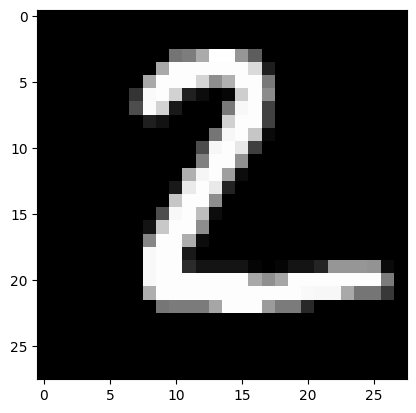

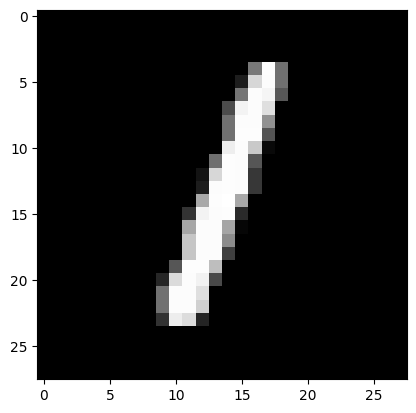

In [13]:
a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        break

In [14]:
params = {
      'depth': 2,
      'width': 1,
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': False
    }

# Create DNN model
model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [15]:
model

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [16]:
# Train and evaluate
trainer = Trainer(model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Batch: 0, Loss: 2.2988688945770264
Batch: 20, Loss: 1.679621696472168
Batch: 40, Loss: 1.281978726387024
Batch: 60, Loss: 0.652273952960968
Batch: 80, Loss: 0.4007314443588257
Batch: 100, Loss: 0.3612010180950165
Batch: 120, Loss: 0.24924878776073456
Batch: 140, Loss: 0.11499082297086716
Batch: 160, Loss: 0.18692833185195923
Batch: 180, Loss: 0.23273912072181702
Batch: 200, Loss: 0.10572396963834763

Average loss: 0.1630, Accuracy: 26165.0/27537 (95%)


Average loss: 0.1889, Accuracy: 2873.0/3059 (94%)

Epoch: 0 	Training Accuracy: 95.02%
Validation Accuracy: 93.92%
Batch: 0, Loss: 0.12397367507219315
Batch: 20, Loss: 0.13805925846099854
Batch: 40, Loss: 0.10154307633638382
Batch: 60, Loss: 0.10549850016832352
Batch: 80, Loss: 0.1335236132144928
Batch: 100, Loss: 0.1198328509926796
Batch: 120, Loss: 0.13561998307704926
Batch: 140, Loss: 0.11358091235160828
Batch: 160, Loss: 0.21463091671466827
Batch: 180, Loss: 0.2897544503211975
Batch: 200, Loss: 0.11882569640874863

Average loss: 0.1

In [17]:
accuracy = eval(model, device, dataloader_wrapped.test_loader, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])


Average loss: 0.0509, Accuracy: 5060.0/5139 (98%)



conv0.weight: 3.5016
conv1.weight: 4.0647
fc_1.weight: 75.4789
fc_2.weight: 8.6079


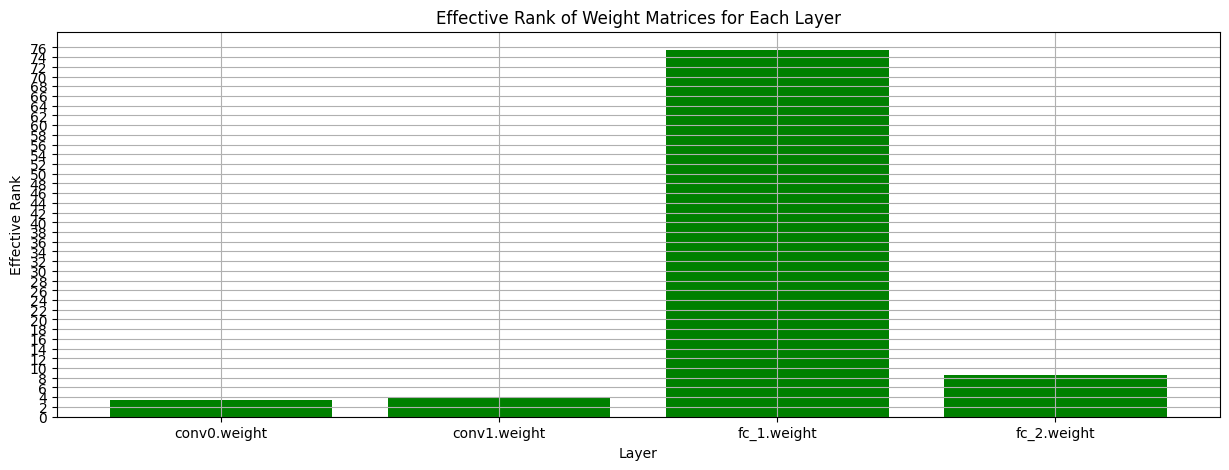

In [18]:
def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

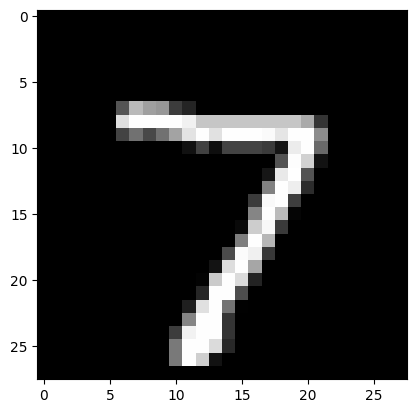

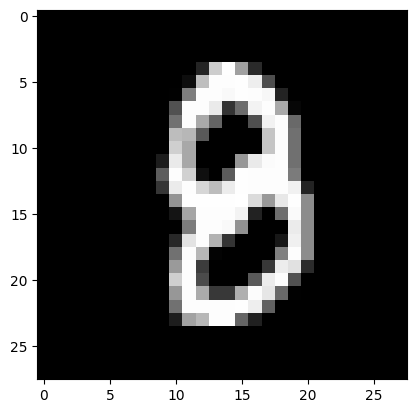

-------------


In [19]:
dataloader_wrapped.update_phase('finetune')

a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break


## Baseline model: end2end with the same architecture as the preatining model

In [20]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
print("Current dataloader phase: ", dataloader_wrapped.get_current_phase())

model_finetuning_baseline = generate_cnn(input_dim = 28, output_dim = 5, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
model_finetuning_baseline.to(device)

# dataloader_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
# train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs_cnn(model_finetuning_baseline, dataloader_wrapped, params, debug=True)

trainer = Trainer(model, dataloader_wrapped, params)
train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Current dataloader phase:  finetune
Batch: 0, Loss: 7.026913642883301
Batch: 20, Loss: 2.1879594326019287
Batch: 40, Loss: 1.0139694213867188
Batch: 60, Loss: 0.9219241738319397
Batch: 80, Loss: 0.8095496296882629
Batch: 100, Loss: 0.6548382043838501
Batch: 120, Loss: 0.41667303442955017
Batch: 140, Loss: 0.4559692442417145
Batch: 160, Loss: 0.5858278870582581
Batch: 180, Loss: 0.5162555575370789
Batch: 200, Loss: 0.26906803250312805

Average loss: 0.3755, Accuracy: 23116.0/26464 (87%)


Average loss: 0.3872, Accuracy: 2566.0/2940 (87%)

Epoch: 0 	Training Accuracy: 87.35%
Validation Accuracy: 87.28%
Batch: 0, Loss: 0.30405551195144653
Batch: 20, Loss: 0.3087233006954193
Batch: 40, Loss: 0.25764238834381104
Batch: 60, Loss: 0.4023982584476471
Batch: 80, Loss: 0.2617571949958801
Batch: 100, Loss: 0.27800893783569336
Batch: 120, Loss: 0.21572662889957428
Batch: 140, Loss: 0.23542916774749756
Batch: 160, Loss: 0.25810080766677856
Batch: 180, Loss: 0.265517920255661
Batch: 200, Loss: 0.203

conv0.weight: 3.8347
conv1.weight: 4.5382
fc_1.weight: 107.9744
fc_2.weight: 4.9817


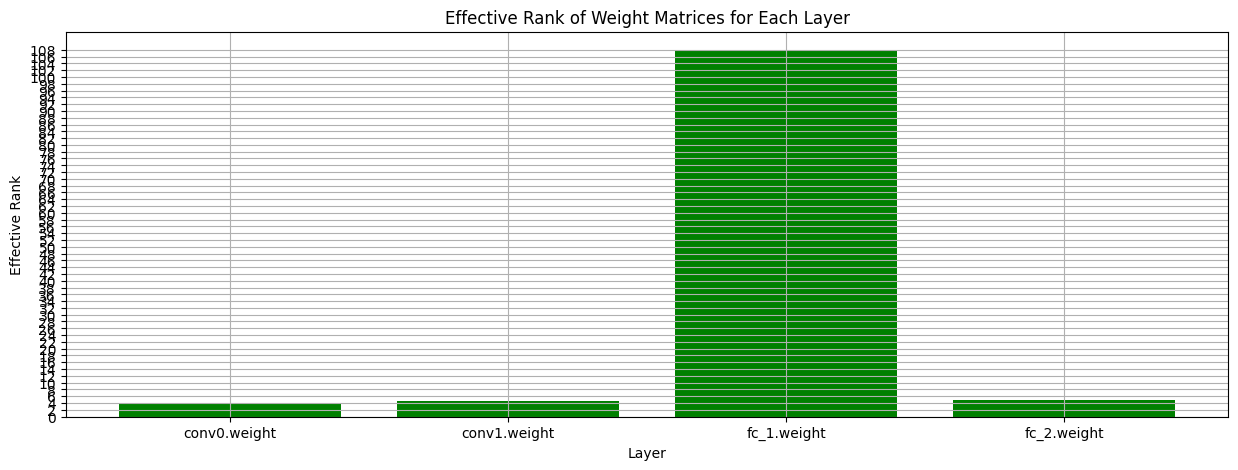

In [21]:
plot_layer_effective_ranks(model_finetuning_baseline)

***WITH BALANCED CLASSES***

Training with different data percentages:   0%|          | 0/10 [00:00<?, ?it/s]

Training for data percentage: 0.01:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 60 =========================
Batch: 0, Loss: 1.6152747869491577

Average loss: 1.6120, Accuracy: 52.0/260 (20%)


Average loss: 1.6125, Accuracy: 599.0/2940 (20%)

Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 20.37%
Batch: 0, Loss: 1.6157612800598145

Average loss: 1.6120, Accuracy: 52.0/260 (20%)


Average loss: 1.6125, Accuracy: 599.0/2940 (20%)

Epoch: 1 	Training Accuracy: 20.00%
Validation Accuracy: 20.37%
Batch: 0, Loss: 1.609192132949829

Average loss: 1.6120, Accuracy: 52.0/260 (20%)


Average loss: 1.6124, Accura

Training for data percentage: 0.03:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 7 =========================
Batch: 0, Loss: 1.614740014076233

Average loss: 1.6068, Accuracy: 182.0/790 (23%)


Average loss: 1.6043, Accuracy: 781.0/2940 (27%)

Epoch: 0 	Training Accuracy: 23.04%
Validation Accuracy: 26.56%
Batch: 0, Loss: 1.6105784177780151

Average loss: 1.6021, Accuracy: 218.0/790 (28%)


Average loss: 1.6001, Accuracy: 910.0/2940 (31%)

Epoch: 1 	Training Accuracy: 27.59%
Validation Accuracy: 30.95%
Batch: 0, Loss: 1.6004588603973389

Average loss: 1.5976, Accuracy: 279.0/790 (35%)


Average loss: 1.5959, Accu

Training for data percentage: 0.05:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 55 =========================
Batch: 0, Loss: 1.5985363721847534

Average loss: 1.6038, Accuracy: 266.0/1320 (20%)


Average loss: 1.6054, Accuracy: 601.0/2940 (20%)

Epoch: 0 	Training Accuracy: 20.15%
Validation Accuracy: 20.44%
Batch: 0, Loss: 1.603468656539917

Average loss: 1.5977, Accuracy: 276.0/1320 (21%)


Average loss: 1.5993, Accuracy: 620.0/2940 (21%)

Epoch: 1 	Training Accuracy: 20.91%
Validation Accuracy: 21.09%
Batch: 0, Loss: 1.5924447774887085

Average loss: 1.5898, Accuracy: 310.0/1320 (23%)


Average loss: 1.5911, 

Training for data percentage: 0.1:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 67 =========================
Batch: 0, Loss: 1.6100796461105347
Batch: 20, Loss: 1.614001989364624

Average loss: 1.6100, Accuracy: 536.0/2645 (20%)


Average loss: 1.6087, Accuracy: 587.0/2940 (20%)

Epoch: 0 	Training Accuracy: 20.26%
Validation Accuracy: 19.97%
Batch: 0, Loss: 1.6149768829345703
Batch: 20, Loss: 1.6111198663711548

Average loss: 1.6099, Accuracy: 530.0/2645 (20%)


Average loss: 1.6087, Accuracy: 610.0/2940 (21%)

Epoch: 1 	Training Accuracy: 20.04%
Validation Accuracy: 20.75%
Batch: 0, Loss: 1.6087197065353394
Ba

Training for data percentage: 0.15:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 67 =========================
Batch: 0, Loss: 1.6064841747283936
Batch: 20, Loss: 1.610388994216919

Average loss: 1.6108, Accuracy: 793.0/3965 (20%)


Average loss: 1.6083, Accuracy: 599.0/2940 (20%)

Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 20.37%
Batch: 0, Loss: 1.6098827123641968
Batch: 20, Loss: 1.6156367063522339

Average loss: 1.6105, Accuracy: 793.0/3965 (20%)


Average loss: 1.6083, Accuracy: 599.0/2940 (20%)

Epoch: 1 	Training Accuracy: 20.00%
Validation Accuracy: 20.37%
Batch: 0, Loss: 1.6066397428512573
Ba

Training for data percentage: 0.2:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 91 =========================
Batch: 0, Loss: 1.6102983951568604
Batch: 20, Loss: 1.6031572818756104
Batch: 40, Loss: 1.5707772970199585

Average loss: 1.5743, Accuracy: 1952.0/5290 (37%)


Average loss: 1.5755, Accuracy: 1075.0/2940 (37%)

Epoch: 0 	Training Accuracy: 36.90%
Validation Accuracy: 36.56%
Batch: 0, Loss: 1.5735894441604614
Batch: 20, Loss: 1.5471373796463013
Batch: 40, Loss: 1.4981697797775269

Average loss: 1.4996, Accuracy: 3319.0/5290 (63%)


Average loss: 1.4999, Accuracy: 1854.0/2940 (63%)

Epoch: 1 	Training Accur

Training for data percentage: 0.4:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 81 =========================
Batch: 0, Loss: 1.6028741598129272
Batch: 20, Loss: 1.622781753540039
Batch: 40, Loss: 1.5936592817306519
Batch: 60, Loss: 1.5862946510314941
Batch: 80, Loss: 1.5596923828125

Average loss: 1.5577, Accuracy: 5335.0/10585 (50%)


Average loss: 1.5557, Accuracy: 1496.0/2940 (51%)

Epoch: 0 	Training Accuracy: 50.40%
Validation Accuracy: 50.88%
Batch: 0, Loss: 1.558642864227295
Batch: 20, Loss: 1.5296354293823242
Batch: 40, Loss: 1.4871314764022827
Batch: 60, Loss: 1.4443241357803345
Batch: 80, Loss: 1.36644

Training for data percentage: 0.6:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 48 =========================
Batch: 0, Loss: 1.611541509628296
Batch: 20, Loss: 1.6096597909927368
Batch: 40, Loss: 1.6210472583770752
Batch: 60, Loss: 1.608879566192627
Batch: 80, Loss: 1.5961934328079224
Batch: 100, Loss: 1.5911916494369507
Batch: 120, Loss: 1.5668275356292725

Average loss: 1.5587, Accuracy: 6318.0/15875 (40%)


Average loss: 1.5611, Accuracy: 1122.0/2940 (38%)

Epoch: 0 	Training Accuracy: 39.80%
Validation Accuracy: 38.16%
Batch: 0, Loss: 1.5515974760055542
Batch: 20, Loss: 1.5221095085144043
Batch: 40, Loss: 1.

Training for data percentage: 0.8:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 9 =========================
Batch: 0, Loss: 1.6020272970199585
Batch: 20, Loss: 1.6177773475646973
Batch: 40, Loss: 1.6152974367141724
Batch: 60, Loss: 1.6045613288879395
Batch: 80, Loss: 1.5991649627685547
Batch: 100, Loss: 1.5980393886566162
Batch: 120, Loss: 1.5927263498306274
Batch: 140, Loss: 1.5721850395202637
Batch: 160, Loss: 1.560741662979126

Average loss: 1.5474, Accuracy: 12510.0/21170 (59%)


Average loss: 1.5502, Accuracy: 1693.0/2940 (58%)

Epoch: 0 	Training Accuracy: 59.09%
Validation Accuracy: 57.59%
Batch: 0, Loss:

Training for data percentage: 1:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 21 =========================
Batch: 0, Loss: 1.617613673210144
Batch: 20, Loss: 1.598154067993164
Batch: 40, Loss: 1.5825895071029663
Batch: 60, Loss: 1.5739731788635254
Batch: 80, Loss: 1.5387651920318604
Batch: 100, Loss: 1.4977378845214844
Batch: 120, Loss: 1.4652435779571533
Batch: 140, Loss: 1.4248089790344238
Batch: 160, Loss: 1.3720508813858032
Batch: 180, Loss: 1.305647611618042
Batch: 200, Loss: 1.2136914730072021

Average loss: 1.2113, Accuracy: 19309.0/26038 (74%)


Average loss: 1.2090, Accuracy: 2137.0/2940 (73%)

Epoch:

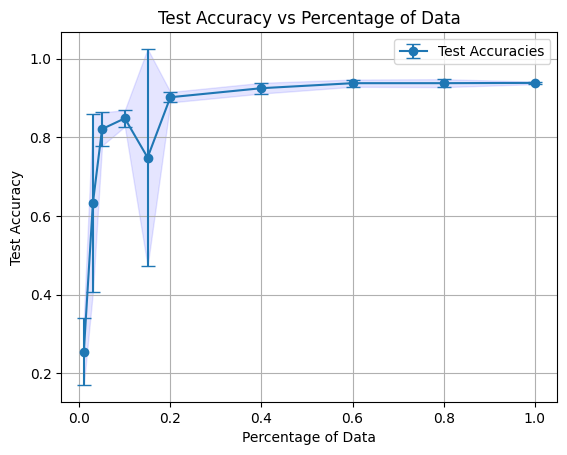

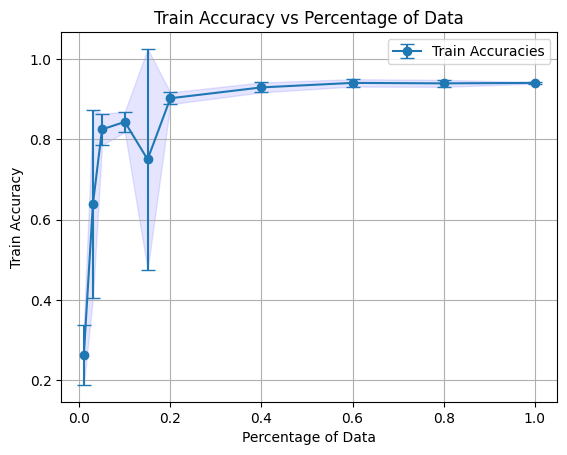

In [22]:
dataloader_wrapped.update_phase('finetune')

percentages = [0.01]
percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]

seed_set = [10, 20, 30, 40, 50]
repeats = 1

params['lr'] = 0.001
params['num_train'] = 20
params['early_stop_patience'] = 6

# Store results for each percentage
results_test = {}
results_train = {}
best_models = {}
data_loaders = {}
epochs_taken = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in tqdm(percentages, desc='Training with different data percentages'):
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []

    for seed in tqdm(seed_set, desc=f'Training for data percentage: {perc}', leave=False):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        
        model_new =  generate_cnn(input_dim = 28, output_dim = 5, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=True)
        model_new.to(device)

        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)

        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        # Train and evaluate the new model on the new data
        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        # Add tqdm write method to prevent progress bar overlap
        tqdm.write(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
        tqdm.write(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

#         print('eval on reduced train set')
#         accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        
#         print('eval on full test set')
#         accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

    results_test[perc] = test_accuracies
    results_train[perc] = train_accuracies
    epochs_taken[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")

# Plot the results
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

## Only heads and data for new classes

now with balanced classes

Processing percentages:   0%|          | 0/10 [00:00<?, ?it/s]

Running seeds for 0.01 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 84 =========================
Batch: 0, Loss: 1.6115912199020386

Average loss: 1.5905, Accuracy: 63.0/260 (24%)


Average loss: 1.5893, Accuracy: 722.0/2940 (25%)

Epoch: 0 	Training Accuracy: 24.23%
Validation Accuracy: 24.56%
Batch: 0, Loss: 1.5934184789657593

Average loss: 1.5753, Accuracy: 74.0/260 (28%)


Average loss: 1.5749, Accuracy: 883.0/2940 (30%)

Epoch: 1 	Training Accuracy: 28.46%
Validation Accuracy: 30.03%
Batch: 0, Loss: 1.584012508392334

Average loss: 1.5621, Accuracy: 86.0/260 (33%)


Average loss: 1.5619, Accura

Running seeds for 0.03 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 93 =========================
Batch: 0, Loss: 1.6274831295013428

Average loss: 1.5919, Accuracy: 160.0/790 (20%)


Average loss: 1.5984, Accuracy: 574.0/2940 (20%)

Epoch: 0 	Training Accuracy: 20.25%
Validation Accuracy: 19.52%
Batch: 0, Loss: 1.601226568222046

Average loss: 1.5539, Accuracy: 212.0/790 (27%)


Average loss: 1.5607, Accuracy: 764.0/2940 (26%)

Epoch: 1 	Training Accuracy: 26.84%
Validation Accuracy: 25.99%
Batch: 0, Loss: 1.5589700937271118

Average loss: 1.5179, Accuracy: 268.0/790 (34%)


Average loss: 1.5253, Acc

Running seeds for 0.05 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 68 =========================
Batch: 0, Loss: 1.6534854173660278

Average loss: 1.5288, Accuracy: 501.0/1320 (38%)


Average loss: 1.5253, Accuracy: 1142.0/2940 (39%)

Epoch: 0 	Training Accuracy: 37.95%
Validation Accuracy: 38.84%
Batch: 0, Loss: 1.5497254133224487

Average loss: 1.4647, Accuracy: 644.0/1320 (49%)


Average loss: 1.4632, Accuracy: 1450.0/2940 (49%)

Epoch: 1 	Training Accuracy: 48.79%
Validation Accuracy: 49.32%
Batch: 0, Loss: 1.4645545482635498

Average loss: 1.4023, Accuracy: 744.0/1320 (56%)


Average loss: 1.402

Running seeds for 0.1 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 47 =========================
Batch: 0, Loss: 1.5977287292480469
Batch: 20, Loss: 1.508559226989746

Average loss: 1.4901, Accuracy: 1180.0/2645 (45%)


Average loss: 1.4856, Accuracy: 1323.0/2940 (45%)

Epoch: 0 	Training Accuracy: 44.61%
Validation Accuracy: 45.00%
Batch: 0, Loss: 1.4797122478485107
Batch: 20, Loss: 1.3909746408462524

Average loss: 1.3706, Accuracy: 1689.0/2645 (64%)


Average loss: 1.3654, Accuracy: 1862.0/2940 (63%)

Epoch: 1 	Training Accuracy: 63.86%
Validation Accuracy: 63.33%
Batch: 0, Loss: 1.379196882247924

Running seeds for 0.15 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 70 =========================
Batch: 0, Loss: 1.5993201732635498
Batch: 20, Loss: 1.5100864171981812

Average loss: 1.4399, Accuracy: 1884.0/3965 (48%)


Average loss: 1.4371, Accuracy: 1397.0/2940 (48%)

Epoch: 0 	Training Accuracy: 47.52%
Validation Accuracy: 47.52%
Batch: 0, Loss: 1.4349932670593262
Batch: 20, Loss: 1.3252837657928467

Average loss: 1.2656, Accuracy: 2745.0/3965 (69%)


Average loss: 1.2634, Accuracy: 2017.0/2940 (69%)

Epoch: 1 	Training Accuracy: 69.23%
Validation Accuracy: 68.61%
Batch: 0, Loss: 1.28763580322265

Running seeds for 0.2 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 58 =========================
Batch: 0, Loss: 1.6451635360717773
Batch: 20, Loss: 1.5087860822677612
Batch: 40, Loss: 1.4311230182647705

Average loss: 1.4052, Accuracy: 3032.0/5290 (57%)


Average loss: 1.4036, Accuracy: 1670.0/2940 (57%)

Epoch: 0 	Training Accuracy: 57.32%
Validation Accuracy: 56.80%
Batch: 0, Loss: 1.4049782752990723
Batch: 20, Loss: 1.2717585563659668
Batch: 40, Loss: 1.2037183046340942

Average loss: 1.1743, Accuracy: 3923.0/5290 (74%)


Average loss: 1.1739, Accuracy: 2190.0/2940 (74%)

Epoch: 1 	Training Accur

Running seeds for 0.4 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 94 =========================
Batch: 0, Loss: 1.6434412002563477
Batch: 20, Loss: 1.5088902711868286
Batch: 40, Loss: 1.4131704568862915
Batch: 60, Loss: 1.2995975017547607
Batch: 80, Loss: 1.1972129344940186

Average loss: 1.1606, Accuracy: 8231.0/10585 (78%)


Average loss: 1.1551, Accuracy: 2255.0/2940 (77%)

Epoch: 0 	Training Accuracy: 77.76%
Validation Accuracy: 76.70%
Batch: 0, Loss: 1.1753838062286377
Batch: 20, Loss: 1.0747992992401123
Batch: 40, Loss: 0.9633640050888062
Batch: 60, Loss: 0.844648003578186
Batch: 80, Loss: 0.7

Running seeds for 0.6 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 99 =========================
Batch: 0, Loss: 1.6480332612991333
Batch: 20, Loss: 1.4992009401321411
Batch: 40, Loss: 1.3875539302825928
Batch: 60, Loss: 1.2798000574111938
Batch: 80, Loss: 1.145021677017212
Batch: 100, Loss: 1.147533893585205
Batch: 120, Loss: 0.9704042077064514

Average loss: 0.9559, Accuracy: 12867.0/15875 (81%)


Average loss: 0.9495, Accuracy: 2373.0/2940 (81%)

Epoch: 0 	Training Accuracy: 81.05%
Validation Accuracy: 80.71%
Batch: 0, Loss: 0.9649303555488586
Batch: 20, Loss: 0.8530527949333191
Batch: 40, Loss: 0

Running seeds for 0.8 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 10 =========================
Batch: 0, Loss: 1.5773017406463623
Batch: 20, Loss: 1.4578551054000854
Batch: 40, Loss: 1.3411602973937988
Batch: 60, Loss: 1.2101428508758545
Batch: 80, Loss: 1.1177622079849243
Batch: 100, Loss: 1.0177123546600342
Batch: 120, Loss: 0.9105917811393738
Batch: 140, Loss: 0.8079909086227417
Batch: 160, Loss: 0.7330067753791809

Average loss: 0.7481, Accuracy: 18081.0/21170 (85%)


Average loss: 0.7486, Accuracy: 2493.0/2940 (85%)

Epoch: 0 	Training Accuracy: 85.41%
Validation Accuracy: 84.80%
Batch: 0, Los

Running seeds for 1 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=144, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 63 =========================
Batch: 0, Loss: 1.5911955833435059
Batch: 20, Loss: 1.4927709102630615
Batch: 40, Loss: 1.3970052003860474
Batch: 60, Loss: 1.2502105236053467
Batch: 80, Loss: 1.1663085222244263
Batch: 100, Loss: 1.0556460618972778
Batch: 120, Loss: 0.9629289507865906
Batch: 140, Loss: 0.860689103603363
Batch: 160, Loss: 0.8211475014686584
Batch: 180, Loss: 0.7338427305221558
Batch: 200, Loss: 0.7060947418212891

Average loss: 0.6532, Accuracy: 22516.0/26038 (86%)


Average loss: 0.6589, Accuracy: 2527.0/2940 (86%)

Epoc

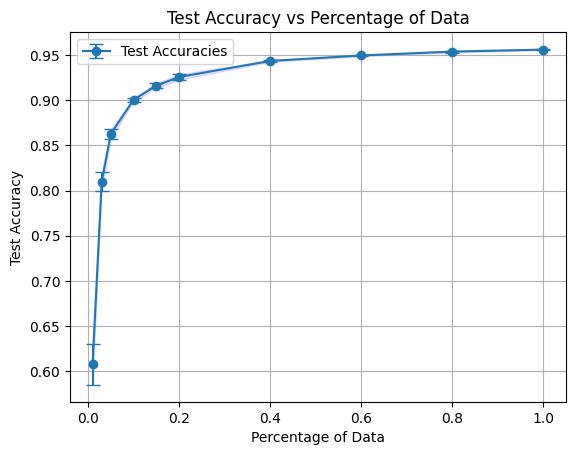

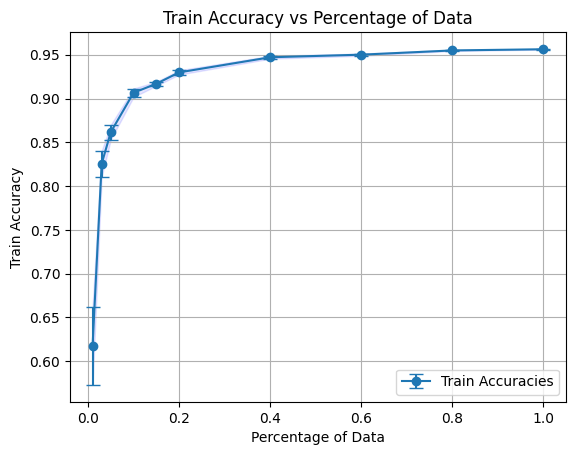

In [23]:
dataloader_wrapped.update_phase('finetune')

percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
seed_set = [10, 20, 30, 40, 50]
repeats = 1

params['lr'] = 0.0001
params['num_train'] = 20
params['early_stop_patience'] = 6

# Store results for each percentage
results_test_finetune = {}
results_train_finetune = {}
best_models = {}
data_loaders = {}
epochs_taken_finetune = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in tqdm(percentages, desc='Processing percentages'):
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []
    
    for seed in tqdm(seed_set, desc=f'Running seeds for {perc} data', leave=False):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

                # Copying model
        model_new = copy.deepcopy(model)

        # Calculate the output size from the pool layer dynamically
        # You would replace this with the actual size based on your model's architecture
        model_new.fc_1 = nn.Linear(144, 128)
    
        # Reinitialize the second fully connected layer
        model_new.fc_2 = nn.Linear(128, 5)
        
        # Ensure the softmax layer matches the number of classes (if used)
        model_new.softmax = nn.Softmax(dim=1)
        
        model_new.to(device)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

#         print('eval on reduced train set')
#         accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        
#         print('eval on full test set')
#         accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

    results_test_finetune[perc] = test_accuracies
    results_train_finetune[perc] = train_accuracies
    epochs_taken_finetune[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")

# Plot the results
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


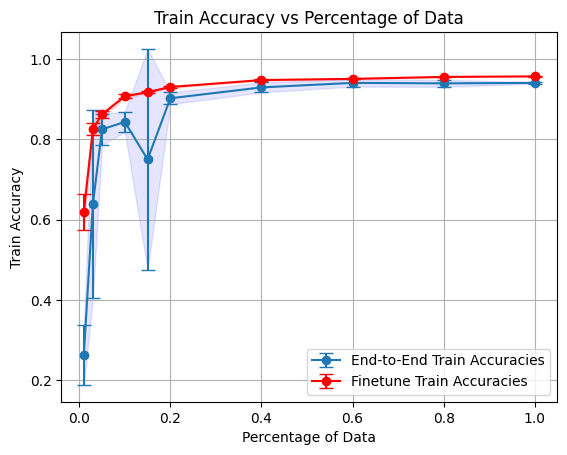

In [24]:
# End to End - Train Accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

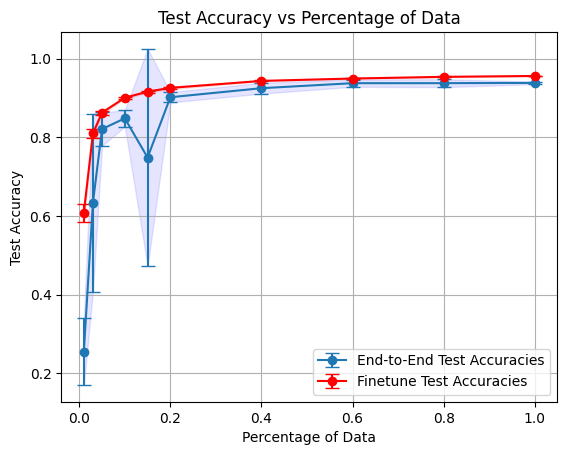

In [25]:
# End to End - Test Accuracies
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]

plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
data_to_save = {
    "results_test_finetune": results_test_finetune,
    "results_train_finetune": results_train_finetune,
    "epochs_taken_finetune": epochs_taken_finetune,
    
    "results_test": results_test,
    "results_train": results_train,
    "epochs_taken": epochs_taken
}

# Assuming data_to_save from the previous code
with open("data.json", "w") as file:
    json.dump(data_to_save, file)

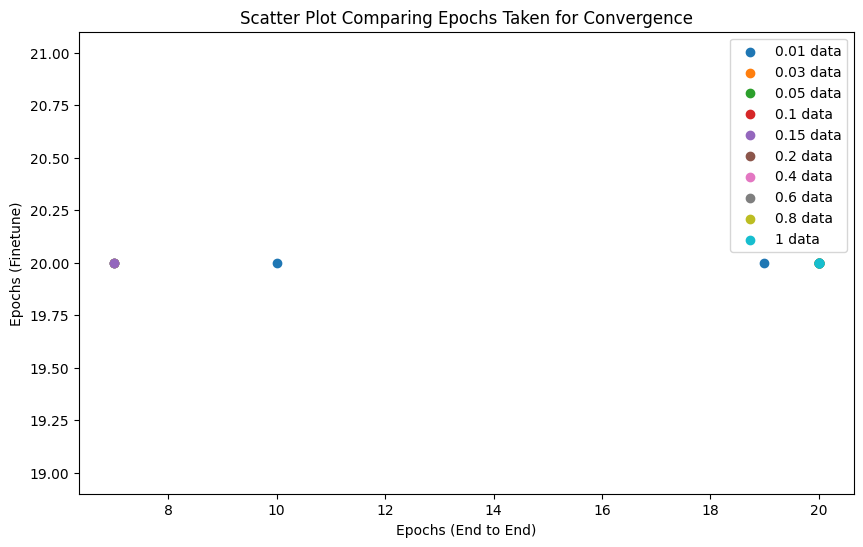

In [27]:
plt.figure(figsize=(10, 6))

for perc in percentages:
    plt.scatter(epochs_taken[perc], epochs_taken_finetune[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()

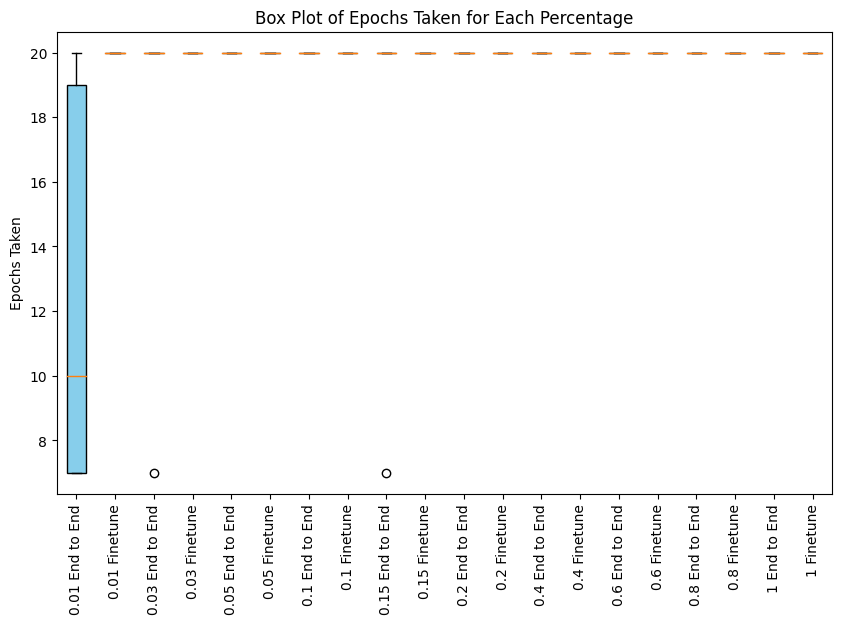

In [28]:
# Given data
percentages = list(epochs_taken.keys())

all_epochs = []
labels = []

for perc in percentages:
    all_epochs.extend([epochs_taken[perc], epochs_taken_finetune[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()
